# Grid Search

To see what range of results I could get by changing optimization parameters, I varied the lungs dose and volume parameters over a grid of points, keeping all other optimization parameters fixed.
I recorded the the resulting lung average dose and PTV D95 dose, which I then compared to the results of the approved treatment plan.

To get a more fair comparison with the approved plan, I also normalized the doses so that the PTV D95 dose was equal to the clinical goal of 4800 Gy. For some plans with lower lung dose and volume parameters, RayStation was not able to normalize the dose due to MLC constraints. For these plans, I was able to extrapolate what the normalized dose might have been.

In the end, it is possible to decrease the average dose to the lungs while maintaining the same PTV D95. My next step will be to explore different methods to quickly identify the optimal lung dose and volume parameters rather than doing a costly grid search.

The RayStation maximum iterations was 40, with conversion after 20 iterations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Approved plan results
dose_approved = 2000
volume_approved = 10
oar_avg_approved = 318.4594544159879
ptv_d95_approved = 4800.13222492 

# Grid search results
oar_avg = np.load('grid_search_40/oar_avg.npy')
ptv_d95 = np.load('grid_search_40/ptv_d95.npy')
oar_avg_norm = np.load('grid_search_40/oar_avg_norm.npy')
ptv_d95_norm = np.load('grid_search_40/ptv_d95_norm.npy')

# Dose-volume histograms
doses_approved = np.load('approved/dvh_doses_approved.npy')
doses_raw = np.load('grid_search_40/dvh_doses_raw.npy')
doses_norm =  np.load('grid_search_40/dvh_doses_norm.npy')
dvh_oar_approved = np.load('approved/dvh_oar_approved.npy')
dvh_oar_raw = np.load('grid_search_40/dvh_oar_raw.npy')
dvh_oar_norm = np.load('grid_search_40/dvh_oar_norm.npy')
dvh_ptv_approved = np.load('approved/dvh_ptv_approved.npy')
dvh_ptv_raw = np.load('grid_search_40/dvh_ptv_raw.npy')
dvh_ptv_norm = np.load('grid_search_40/dvh_ptv_norm.npy')

In [3]:
def plot_lines(results_vec, results_name):
    """Plot results as lines."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Results vs. dose parameter
    for ii in range(10):
        ax[0].plot(np.arange(100, 2001, 100), results_vec[1:, ii], 'o-')
    ax[0].set_xlabel('OAR Dose Parameter')
    ax[0].set_ylabel(results_name)
    
    # Results vs. volume parameter
    for ii in range(1, 20):
        ax[1].plot(np.arange(11), results_vec[ii, :], 'o-')
    ax[1].set_xlabel('OAR Volume Parameter')
    ax[1].set_ylabel(results_name)

def plot_grid(results_vec, results_name, point=None):
    """Plot results as a grid."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Contour plot
    im0 = ax[0].contour(results_vec[1:, :].T)
    ax[0].clabel(im0)
    ax[0].set_xticks(ticks=np.arange(1, 21, 2))
    ax[0].set_xticklabels(labels=np.arange(200, 2001, 200), rotation=90)
    ax[0].set_xlabel('OAR Dose Parameter')
    ax[0].set_ylabel('OAR Volume Parameter')
    
    # Grid plot
    im1 = ax[1].imshow(results_vec[1:, :].T, origin='lower')
    ax[1].set_xticks(ticks=np.arange(1, 21, 2))
    ax[1].set_xticklabels(labels=np.arange(200, 2001, 200), rotation=90)
    ax[1].set_xlabel('OAR Dose Parameter')
    ax[1].set_ylabel('OAR Volume Parameter')
    ax[1].axis('auto')
    plt.colorbar(im1, label=results_name)
    
    # Plot point
    if point is not None:
        ax[0].plot(point[0] - 1, point[1], 'ro')
        ax[1].plot(point[0] - 1, point[1], 'ro')

# OAR Average Dose

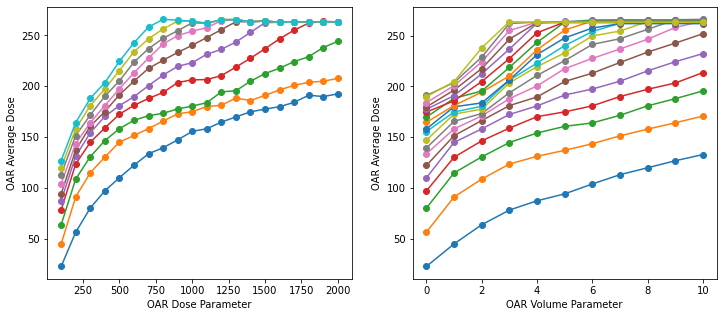

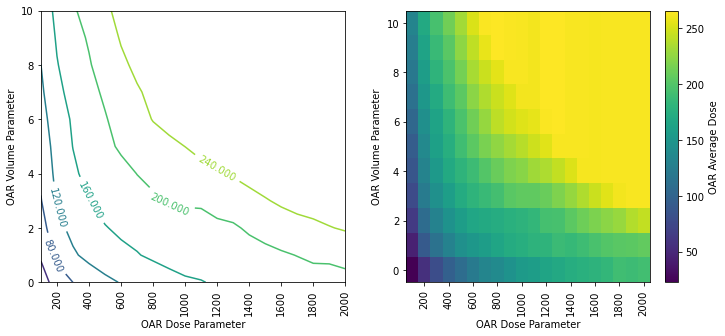

In [4]:
plot_lines(oar_avg, 'OAR Average Dose')
plot_grid(oar_avg, 'OAR Average Dose')

# PTV D95 Dose

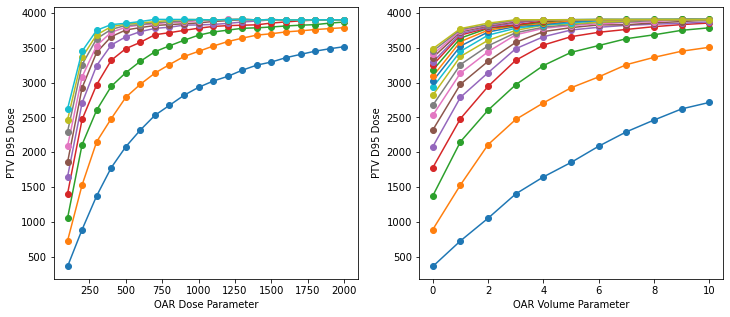

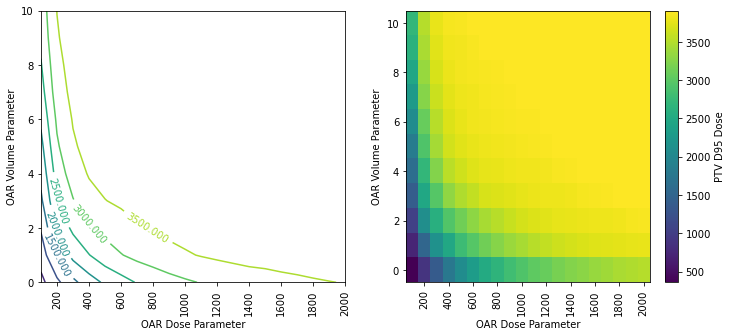

In [5]:
plot_lines(ptv_d95, 'PTV D95 Dose')
plot_grid(ptv_d95, 'PTV D95 Dose')

# OAR dose vs. PTV dose

Without normalization, the grid search plans have lower doses.

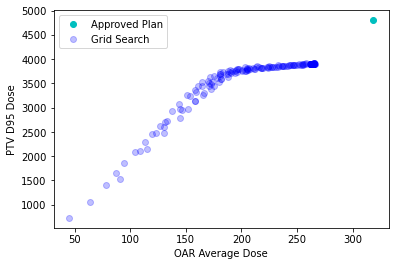

In [6]:
plt.plot(oar_avg_approved, ptv_d95_approved, 'co')
for ii in range(1, 21):
    for jj in range(1, 11):
        plt.plot(oar_avg[ii, jj], ptv_d95[ii, jj], 'bo', alpha=0.25)
plt.xlabel('OAR Average Dose')
plt.ylabel('PTV D95 Dose')
plt.legend(['Approved Plan', 'Grid Search']);

# Normalized OAR Average Dose

We normalize plans so that the PTV D95 = 4800 Gy.
Where RayStation wasn't able to normalize the plan, the OAR average dose is set to -1.

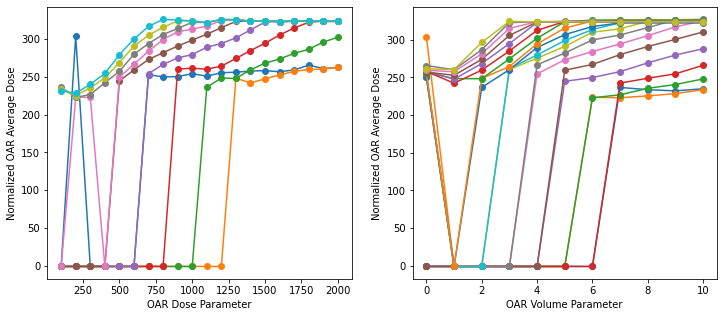

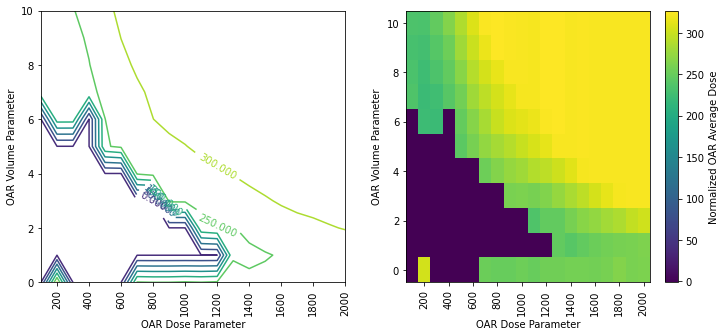

In [7]:
plot_lines(oar_avg_norm, 'Normalized OAR Average Dose')
plot_grid(oar_avg_norm, 'Normalized OAR Average Dose')

# Estimation

We can use the fact that the normalized dose is close to 4800*(oar dose)/(ptv dose) to estimate the missing values.

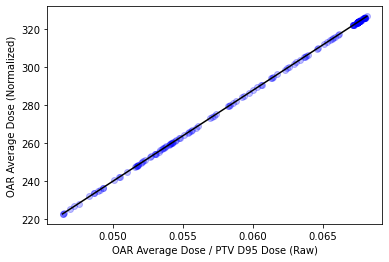

In [8]:
# Plot raw ratio vs. normalized dose 
plt.plot(oar_avg[oar_avg_norm > -1]/ptv_d95[oar_avg_norm > -1], oar_avg_norm[oar_avg_norm > -1], 'bo', alpha=0.25)
plt.xlabel('OAR Average Dose / PTV D95 Dose (Raw)')
plt.ylabel('OAR Average Dose (Normalized)');

# Plot line with slope 4800
left = min(oar_avg[oar_avg_norm > -1]/ptv_d95[oar_avg_norm > -1])
right = max(oar_avg[oar_avg_norm > -1]/ptv_d95[oar_avg_norm > -1])
plt.plot([left, right], [4800*left, 4800*right], 'k');

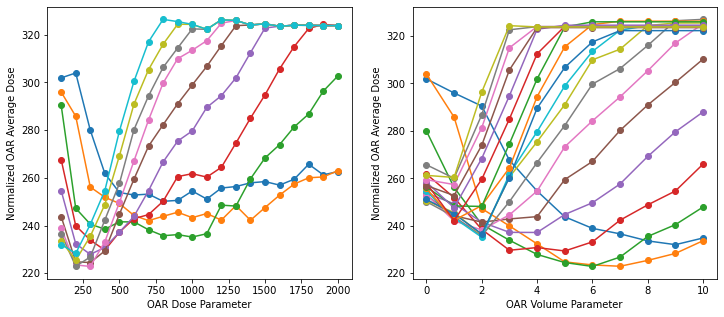

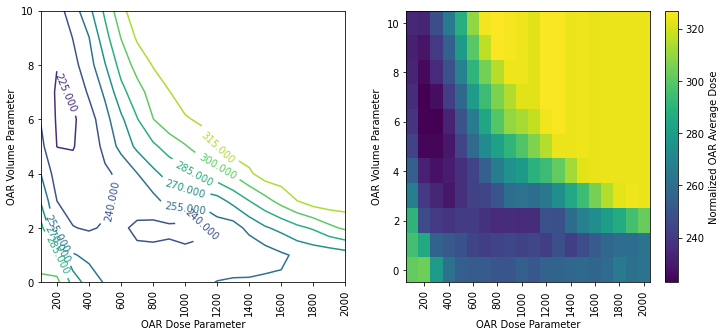

In [9]:
oar_avg_est = oar_avg_norm.copy()
oar_avg_est[oar_avg_norm == -1] = 4800*oar_avg[oar_avg_norm == -1]/ptv_d95[oar_avg_norm == -1]
plot_lines(oar_avg_est, 'Normalized OAR Average Dose')
plot_grid(oar_avg_est, 'Normalized OAR Average Dose')

# Optimal Point

Finally, we identify the grid search plan that results in the lowest OAR average dose.
This plan also achieves the lowest ratio of raw OAR average dose to PTV D95 dose. 

Dose: 300, Volume: 6, Min dose: 222.86260469154263


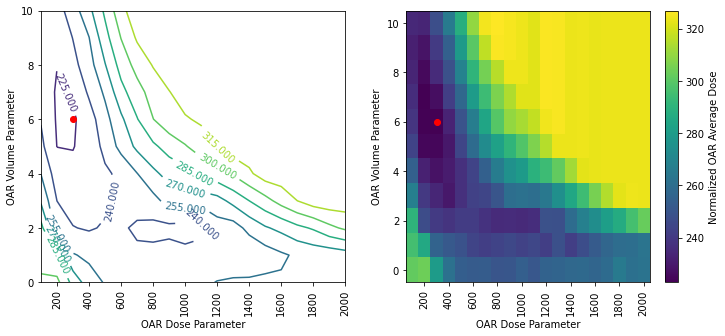

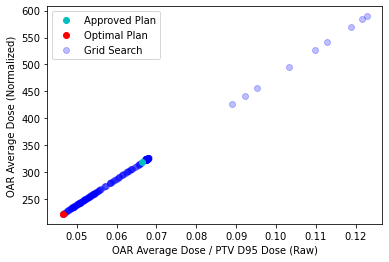

In [10]:
# Find optimal point
min_dose = 1e6
opt_dose = -1
opt_volume = -1
for ii in range(1, 21):
    for jj in range(1, 11):
        if oar_avg_est[ii, jj] < min_dose:
            min_dose = oar_avg_est[ii, jj]
            opt_dose =  ii
            opt_volume = jj
print(f'Dose: {100*opt_dose}, Volume: {opt_volume}, Min dose: {min_dose}')

# Plot results with optimal point
plot_grid(oar_avg_est, 'Normalized OAR Average Dose', point=[opt_dose, opt_volume]);

# Plot normalized dose vs. ratio with approved plan and optimal plan
plt.figure()
plt.plot(oar_avg_approved/ptv_d95_approved, oar_avg_approved, 'co', zorder=3)
plt.plot(oar_avg[opt_dose, opt_volume]/ptv_d95[opt_dose, opt_volume], oar_avg_est[opt_dose, opt_volume], 'ro', zorder=3)
plt.plot(oar_avg[oar_avg > -1]/ptv_d95[oar_avg > -1], oar_avg_est[oar_avg > -1], 'bo', alpha=0.25)
plt.xlabel('OAR Average Dose / PTV D95 Dose (Raw)')
plt.ylabel('OAR Average Dose (Normalized)')
plt.legend(['Approved Plan', 'Optimal Plan', 'Grid Search']);

# Compare DVH of approved and optimal plans

Obviously, we need to consider multiple criteria when choosing optimal plans, as in this case only considering the OAR average dose meant that we sacrificed PTV dose uniformity.

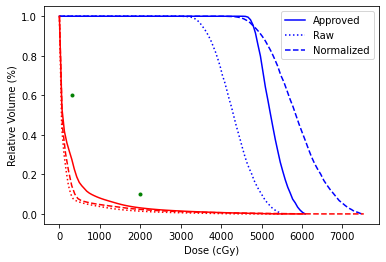

In [11]:
plt.plot(doses_approved, dvh_ptv_approved, 'b')
plt.plot(doses_raw, dvh_ptv_raw, 'b:')
plt.plot(doses_norm, dvh_ptv_norm, 'b--')
plt.plot(doses_approved, dvh_oar_approved, 'r')
plt.plot(doses_raw, dvh_oar_raw, 'r:')
plt.plot(doses_norm, dvh_oar_norm, 'r--')
plt.plot(300, 0.6, 'g.')
plt.plot(2000, 0.1, 'g.')
plt.xlabel('Dose (cGy)')
plt.ylabel('Relative Volume (%)')
plt.legend(['Approved', 'Raw', 'Normalized'])